# Match Terms and Visualize

This notebook uses the results from the `parse_resources.ipynb` notebook.
The parse resources step pulls data from ArchivesSpace and creates a
dataframe that was output to a CSV file. 
This notebook starts from the CSV file, but it could
relatively easily be changed to take the previous dataframe
as an input. 

## Setup

If continuing or adapting this code, you have likely already imported these libraries.
We will use `pandas` for data processing, `re` for text processing and parsing,
and a few others.

In [1]:
import pandas as pd 
import re

#import numpy as np
#import os
#import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.io as pio

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


**pd.set_option('display.max_colwidth', -1)**: controls the maximum width of each column in a pandas dataframe. By setting it to -1, pandas will display the full contents of each column, without any truncation:

In [2]:
#pd.set_option('display.max_colwidth', -1)

**pd.set_option('display.max_rows', None)**: Sets the maximum number of rows displayed when a pandas DataFrame or Series is printed to be unlimited. When this option is set to an integer (as in the commented line # **pd.set_option('display.max_rows', 10)**), only the specified number of rows would be displayed. This is useful for controlling the output length, especially when working with large DataFrames.

In [3]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', 10)

Note: the following functions and code is based on
work by Ella Li, who created an initial version of this project
that parsed EAD data from XML files. 
The process here is similar but
continues to use the data pulled from the ArchivesSpace API,
which exports data in JSON rather than XML. 

## Provide Terms

Terms of interest are supplied in a plain text file, with
each term of interest on its own line. 

In [2]:
# read in the txt file term list
term_list_file = 'terms_all.txt'

with open(term_list_file, 'r') as f:
    terms = [line.strip() for line in f]

In [3]:
print(f'Read term list from {term_list_file} and recorded {len(terms)} terms of interest.')

Read term list from terms_all.txt and recorded 104 terms of interest.


## Match Terms

The next block defines the `match_terms` function, which analyses the EAD data
and identify occurences, tally occurences, and record their source tags.
First, pull the CSV `results.csv` data into a dataframe.
Then, the function searches for each term in the specified columns of a given row in your DataFrame. It performs an exact match, searching for the whole term, not part of it (due to the use of the `\b` word boundary in the regular expression). The search is case-insensitive due to the `re.IGNORECASE` flag.

If a term is found in a paragraph of the column, a dictionary is created with details about the match, including the term, the number of matches in the paragraph, the paragraph text itself, and other related information. These dictionaries are appended to the results list.

In [4]:
# match term

def match_terms(row, terms, columns):
    results = []
    for term in terms:
        for col in columns:
            if not isinstance(row[col], float):
                # split the column into paragraphs
                # wonky try/except to work through integers, if not converted to strings
                try:
                    paragraphs = row[col].split('\n')
                except:
                    paragraphs = str(row[col]).split('\n')
                # loop through each paragraph
                for paragraph in paragraphs:
                    # check if the term is in the current paragraph
                    if re.search(r'\b' + re.escape(term) + r'\b', paragraph, re.IGNORECASE):
                        results.append({
                            'ead_id': row['ead_id'],
#                            'source_filename': row['source_filename'],
                            'resource_id': row['resource_id'],
                            'titleproper': row.get('titleproper', None), 
                            'Term': term, 
                            'Matched_Times': len(re.findall(r'\b' + re.escape(term) + r'\b', paragraph, re.IGNORECASE)),
                            'Matched_From': col, 
                            'Matched_Paragraph': paragraph
                        })
    return results

Next, using the match term function, tally and record the results.
These outputs will be the basis of additional reports and visualizations,
including the term in context report, charts, and other visualizations.

In [5]:
def match_and_visualize(df, name):
    # Match results
    results_df = pd.DataFrame([result for index, row in df.iterrows() for result in match_terms(row, terms, df.columns)])
    
    # Show matched results
    print('Matched results for', name)
    display(results_df) # control dislay

    # Export to CSV
    results_df.to_csv('matched_results_' + name + '.csv', index=True)
    return results_df  # Return the DataFrame for later use

To use the above functions, create a dataframe (or reuse the data from the `parse_resources.ipynb` scripts), then initialize the functions. 
The following code block demonstrates how to do this with `results.csv`
as an input.

In [6]:
eads_df = pd.read_csv('results.csv', encoding='utf-8')

In [7]:
eads_df.head()

,resource_id,eadid,titleproper,abstract,language,scopecontent,bioghist,subjects,subjects_source,genreforms,genreforms_source,geognames,geognames_source,persnames,persnames_source,corpnames,corpnames_source,famnames,famnames_source
0,3011,umich-bhl-00138,the Ralph M. Hodnett papers,NaN,The finding aid is written in English,This collection consists of reminiscences (wri...,Ralph M. Hodnett was an officer in the U.S. Ar...,"Soldiers; World War, 1914-1918; Soldiers",lcsh; lcsh; lctgm,Diaries.; Photographs.,lcsh; gmgpc,Philippines,lcsh,"Hodnett, Ralph M.; Hodnett, Ralph M.",lcnaf; lcnaf,United States. Army.,lcnaf,Oram family.,lcnaf
1,267,umich-bhl-0052,Bentley Historical Library publications. 1935-...,The Bentley Historical Library (BHL) houses th...,The finding aid is written in English,The PUBLICATIONS (3.7 linear feet) are divided...,The origins of the Bentley Historical Library ...,NaN,NaN,Annual reports.; Newsletters.; Bibliographies....,aat; aat; aat; aat; aat; aat; aat; aat; aat,NaN,NaN,NaN,NaN,Bentley Historical Library.; Michigan Historic...,lcnaf; lcnaf; lcnaf,NaN,NaN
2,996,umich-bhl-0142,the Frank C. Gates papers,Frank C. Gates was a professor of botany at th...,The finding aid is written in <language encodi...,The Frank C. Gates papers are dated from 1871-...,"Frank Caleb Gates was born on September 12, 18...",Bird watching.; Botany; Forests and forestry; ...,lcsh; lcsh; lcsh; aat,Lantern slides.; Photographs.; Postcards.,aat; aat; aat,Philippines; Plants,lcsh; lctgm,"Gates, Frank C. (Frank Caleb), 1887-1955; Gate...",lcnaf; lcnaf; lcnaf,University of the Philippines.,lcnaf,NaN,NaN
3,2722,umich-bhl-03171,"Mike Wallace CBS 60 Minutes Papers, 1922-2007","Papers of Mike Wallace (1918-2012), broadcast ...",The finding aid is written in English,"The Mike Wallace CBS/ <title render=""italic"">6...",Mike Wallace was born Myron Leon Wallace on Ma...,60 minutes (Television program); Television br...,lcsh; lcsh; lcsh; lcsh; lcsh; lcsh; lcsh; lcsh...,Photographs.; Sound recordings.; Videotapes.,aat; aat; aat,NaN,NaN,"Wallace, Mike, 1918-2012; Wallace, Mike, 1918-...",lcnaf; lcnaf; lcnaf; lcnaf,CBS News.; CBS News.,lcnaf; lcnaf,NaN,NaN
4,1051,umich-bhl-0336,"Grant Kohn Goodman papers, 1943-1995",Grant K. Goodman was a student at the Universi...,The finding aid is written in English,The Grant K. Goodman collection documents the ...,Grant Kohn Goodman was born in 1924 in Clevela...,"World War, 1939-1945; World War, 1939-1945; Wo...",lcsh; lcsh; lcsh,Digital file formats.; Photographs.; Sound rec...,aat; aat; aat; aat,Tokyo.,lcsh,"Goodman, Grant Kohn, 1924-2014; Goodman, Grant...",lcnaf; lcnaf,United States. Army. Japanese Language School ...,lcnaf; lcnaf; lcnaf,NaN,NaN


In [9]:
eads_df.columns

Index(['resource_id', 'eadid', 'titleproper', 'abstract', 'language',
       'scopecontent', 'bioghist', 'subjects', 'subjects_source', 'genreforms',
       'genreforms_source', 'geognames', 'geognames_source', 'persnames',
       'persnames_source', 'corpnames', 'corpnames_source', 'famnames',
       'famnames_source'],
      dtype='object')

In [8]:
# rename eadid to ead_id
eads_df = eads_df.rename(columns={'eadid':'ead_id'})

## Tally and Record

Use the `match_and_visualize()` function to count the matches.

In [9]:
match_and_visualize(eads_df, 'Bentley')

Matched results for Bentley


,ead_id,resource_id,titleproper,Term,Matched_Times,Matched_From,Matched_Paragraph
0,umich-bhl-0336,1051,"Grant Kohn Goodman papers, 1943-1995",Death,1,bioghist,Goodman worked as a professor of Japanese hist...
1,umich-bhl-0375,2620,Museum of Anthropological Archaeology (Univers...,Native,1,bioghist,The Division of Ethnology was established to ...
2,umich-bhl-0420,9275,"the Albert Kahn Associates records, 1825-2014",Death,1,abstract,"Albert Kahn was a Detroit-based architect, act..."
3,umich-bhl-0420,9275,"the Albert Kahn Associates records, 1825-2014",Death,1,scopecontent,The narrative and visual materials in the coll...
4,umich-bhl-0420,9275,"the Albert Kahn Associates records, 1825-2014",Death,1,bioghist,The final chapter in Kahn's industrial archit...
...,...,...,...,...,...,...,...
178,umich-bhl-9573,510,Walker Lee Cisler Papers,Death,1,bioghist,Walker Cisler remained active in his many end...
179,umich-bhl-9833,985,Edward Gajec Papers,Death,1,bioghist,"Edward Gajec was a musician, a music educator,..."
180,umich-bhl-9840,1466,"Charles W. Lane papers, 1935-1997",Types,1,scopecontent,"The collection is arranged into five series, B..."
181,umich-bhl-9940,295,"James J. Blanchard Papers, 1982-2002",Remains,2,scopecontent,The Personnel Division was charged with filli...


,ead_id,resource_id,titleproper,Term,Matched_Times,Matched_From,Matched_Paragraph
0,umich-bhl-0336,1051,"Grant Kohn Goodman papers, 1943-1995",Death,1,bioghist,Goodman worked as a professor of Japanese hist...
1,umich-bhl-0375,2620,Museum of Anthropological Archaeology (Univers...,Native,1,bioghist,The Division of Ethnology was established to ...
2,umich-bhl-0420,9275,"the Albert Kahn Associates records, 1825-2014",Death,1,abstract,"Albert Kahn was a Detroit-based architect, act..."
3,umich-bhl-0420,9275,"the Albert Kahn Associates records, 1825-2014",Death,1,scopecontent,The narrative and visual materials in the coll...
4,umich-bhl-0420,9275,"the Albert Kahn Associates records, 1825-2014",Death,1,bioghist,The final chapter in Kahn's industrial archit...
...,...,...,...,...,...,...,...
178,umich-bhl-9573,510,Walker Lee Cisler Papers,Death,1,bioghist,Walker Cisler remained active in his many end...
179,umich-bhl-9833,985,Edward Gajec Papers,Death,1,bioghist,"Edward Gajec was a musician, a music educator,..."
180,umich-bhl-9840,1466,"Charles W. Lane papers, 1935-1997",Types,1,scopecontent,"The collection is arranged into five series, B..."
181,umich-bhl-9940,295,"James J. Blanchard Papers, 1982-2002",Remains,2,scopecontent,The Personnel Division was charged with filli...


The `calculate_term_frequency()` function uses the matched term list
and regroups according to the matched terms and tallies the frequncy of the terms.

In [10]:
def calculate_term_frequency(df, df_name):
    term_frequency = df.groupby('Term')['Matched_Times'].sum().reset_index()
    term_frequency.rename(columns={'Matched_Times': 'Total_Frequency'}, inplace=True)
    term_frequency['DataFrame'] = df_name

    # Sort in descending order
    term_frequency.sort_values(by='Total_Frequency', ascending=False, inplace=True)
    
    # Show frequency table
    print('Term frequency for', df_name)
    display(term_frequency)

    return term_frequency

## Match from multiple sources

In our originating use case at the University of Michigan,
we were interested to see how the terms were used across different
collections. We were, specifically, working with three on-campus repositories:
the Bentley Historical Library, Clements Library, and the Special Collections Research Center (part of the University Library).

If you are working with multiple groups of finding aids, 
you might adapt the following code, which concatenates multiple
lists (may be provided as dataframes or CSVs) and tallies across them. 

In [ ]:
# for each dataframe representing matched terms
file_list = [(df1_Bentley, 'Bentley'), (df2_Clements, 'Clements'), (df3_SCRC, 'SCRC')]
matched_results = {name: match_and_visualize(df, name) for df, name in file_list}

# Visualize matches

This should probably be split to its own file, but here for dev purposes

### Visualization values

Use the below to set global values, such as the names of repositories
under analysis, or fonts and colors for charts. 

In [11]:
# set names and colors here
repo_list = ['Bentley']
#repo_list = ['Bentley','Clements','SCRC']
global_font_info = {'font_family':'Georgia'}
colors = {'Bentley': '#CFC096', 'Clements': '#A5A508', 'SCRC': '#FFCB05'}
project_name = 'RCRC Finding Aids'

# create a manifest to select which result lists you want to visualize
match_groups = [(eads_df, 'Bentley')]
matched_results = {name: match_and_visualize(df, name) for df, name in match_groups}

Matched results for Bentley


,ead_id,resource_id,titleproper,Term,Matched_Times,Matched_From,Matched_Paragraph
0,umich-bhl-0336,1051,"Grant Kohn Goodman papers, 1943-1995",Death,1,bioghist,Goodman worked as a professor of Japanese hist...
1,umich-bhl-0375,2620,Museum of Anthropological Archaeology (Univers...,Native,1,bioghist,The Division of Ethnology was established to ...
2,umich-bhl-0420,9275,"the Albert Kahn Associates records, 1825-2014",Death,1,abstract,"Albert Kahn was a Detroit-based architect, act..."
3,umich-bhl-0420,9275,"the Albert Kahn Associates records, 1825-2014",Death,1,scopecontent,The narrative and visual materials in the coll...
4,umich-bhl-0420,9275,"the Albert Kahn Associates records, 1825-2014",Death,1,bioghist,The final chapter in Kahn's industrial archit...
...,...,...,...,...,...,...,...
178,umich-bhl-9573,510,Walker Lee Cisler Papers,Death,1,bioghist,Walker Cisler remained active in his many end...
179,umich-bhl-9833,985,Edward Gajec Papers,Death,1,bioghist,"Edward Gajec was a musician, a music educator,..."
180,umich-bhl-9840,1466,"Charles W. Lane papers, 1935-1997",Types,1,scopecontent,"The collection is arranged into five series, B..."
181,umich-bhl-9940,295,"James J. Blanchard Papers, 1982-2002",Remains,2,scopecontent,The Personnel Division was charged with filli...


## Visualize group matches

In the use case at U Michigan, the groups represented finding aids
created by different repositories on campus. This can be useful for
working with subgroups of finding aids, or in comparing usage between
different organizations.

In [12]:
# bar charts for individual groups

def visualize_individual_repository_terms_bar(list_of_dataframes):
    '''
    This function takes a list of strings (list_of_dataframes), which identify the names of dataframes (corresponding to an archival repository),
    then generates a bar chart to show how many times a list of requested terms appears in the corresponding finding aid documents.
    Requires the calculate_term_frequency function.
    Processes data using pandas and generates charts using plotly (px) & plotly express (pio).
    '''
    for i in range(len(list_of_dataframes)):
        # calculate term frequency
        term_frequency = calculate_term_frequency(matched_results[repo_list[i]], repo_list[i])
        term_frequency.head()

        # Visualization in Multiple Charts
        fig = px.bar(term_frequency, x='Term', y='Total_Frequency', text='Total_Frequency', 
                        color='DataFrame', color_discrete_map=colors, text_auto=True,
                        labels={'Total_Frequency':'Term Occurence Count','DataFrame':'Repository'})
        fig.update_traces(textposition='outside', insidetextanchor='middle',
                          textfont=dict(family='Arial', size=8))
        fig.update_layout(title_text=f'Term Frequency for { repo_list[i] } ({ project_name })', 
                          xaxis_title_standoff=10, 
                          showlegend=False, font_family=global_font_info['font_family'])
        fig.update_xaxes(tickangle=45, tickfont=dict(family='Arial', color='black', size=10))
        fig.update_yaxes(tickfont=dict(family='Arial', size=10))
        fig.show()
        pio.write_image(fig, f'term_frequency_byrepo_{ repo_list[i] }.png', width=700)

visualize_individual_repository_terms_bar(repo_list)

Term frequency for Bentley


,Term,Total_Frequency,DataFrame
5,Death,51,Bentley
19,Philippine Islands,33,Bentley
17,Native,21,Bentley
6,Dwellings,19,Bentley
10,Igorot,15,Bentley
29,Types,8,Bentley
22,Remains,5,Bentley
21,Race,5,Bentley
11,Igorots,5,Bentley
0,Colonial,5,Bentley


The above shows a basic bar chart, ordered from most frequent
to least frequent term. If looking at multiple groupings, the above
function will create multiple bar charts. 

The following sections demonstrate additional visualizations, for a single grouping
of finding aid data. For the case of multiple groups (or, in our case repositories)
see the additional visualization notebooks.

## Visualization: occurence in a horizontal bar chart

In [17]:
# bar charts for individual repos - horizontal

def visualize_individual_repository_terms_bar_horiz(list_of_dataframes):
    '''
    This function takes a list of strings (list_of_dataframes), which identify the names of dataframes (corresponding to an archival repository),
    then generates a horizontal bar chart to show how many times a list of requested terms appears in the corresponding finding aid documents.
    Requires the calculate_term_frequency function.
    Processes data using pandas and generates charts using plotly (px) & plotly express (pio).
    '''
    for i in range(len(list_of_dataframes)):
        # calculate term frequency
        term_frequency = calculate_term_frequency(matched_results[repo_list[i]], repo_list[i]).sort_values('Total_Frequency', ascending=True)
        term_frequency.head()

        # Visualization in Charts Horizontallly
        fig = px.bar(term_frequency, y='Term', x='Total_Frequency', text='Total_Frequency',
                        color='DataFrame', color_discrete_map=colors, text_auto=True,
                        labels={'Total_Frequency':'Term Occurence Count','DataFrame':'Repository'})
        fig.update_traces(textposition='outside', insidetextanchor='middle', 
                          textfont=dict(family='Arial',size=8))
        fig.update_layout(title_text=f'Term Frequency for { repo_list[i] } ({project_name})',
                          xaxis_title_standoff=10, height=600, 
                          showlegend=False, font_family=global_font_info['font_family'])
        fig.update_yaxes(tickfont=dict(family='Arial', size=10))
        fig.update_xaxes(tickangle=0, tickfont=dict(family='Arial', color='black', size=10))
        fig.show()
        pio.write_image(fig, f'term_frequency_byrepo_{ repo_list[i] }_horizbar.png', scale=4)

visualize_individual_repository_terms_bar_horiz(repo_list)

Term frequency for Bentley


,Term,Total_Frequency,DataFrame
5,Death,51,Bentley
19,Philippine Islands,33,Bentley
17,Native,21,Bentley
6,Dwellings,19,Bentley
10,Igorot,15,Bentley
29,Types,8,Bentley
22,Remains,5,Bentley
21,Race,5,Bentley
11,Igorots,5,Bentley
0,Colonial,5,Bentley


The horizontal bar chart seems more well-suited to displaying occurences
of the terms, since the terms are easier to read in this orientation.

## Visualization: Occurence by EAD tag/element

This section of the script helps identify the EAD (Encoded Archival Description) elements with the highest occurrences of the specified harmful terms.

The function `calculate_element_frequency(df, df_name)` is used to calculate the sum of matched terms for each subsection in a DataFrame. The results are sorted in descending order and returned as a DataFrame with columns `Subsection`, `harmful_terms_frequency`, and `Source`.

This function is applied to each DataFrame in matched_results, and the results are concatenated into a single DataFrame, `all_element_frequencies`.

Finally, a grouped bar chart is created to visualize the frequency of terms across different subsections and sources.

In the chart, the x-axis represents the subsections, the y-axis shows the frequency of harmful terms, and different colors distinguish between sources. The `barmode='group'` setting places the bars side by side for easier comparison between sources.

In [18]:
def calculate_element_frequency(df, df_name):
    element_counts = df.groupby('Matched_From')['Matched_Times'].sum()
    element_counts_sorted = element_counts.sort_values(ascending=False)
    df_element_counts = pd.DataFrame(list(element_counts_sorted.items()), columns=['Subsection', 'harmful_terms_frequency'])
    df_element_counts['Source'] = df_name  # Indicate the source dataframe
    return df_element_counts

# Use the function for each dataframes
element_frequencies_list = [calculate_element_frequency(df, name) for name, df in matched_results.items()]

# Concatenate all element frequencies
all_element_frequencies = pd.concat(element_frequencies_list)

# Show the DataFrame
print("Element frequencies across all file pools:")
display(all_element_frequencies)

# Set colors
colors = {'Bentley': '#CFC096', 'Clements': '#A5A508', 'SCRC': '#FFCB05'}

# Visualization
fig = px.bar(all_element_frequencies, x='Subsection', y='harmful_terms_frequency', color='Source', 
             text='harmful_terms_frequency', barmode='group',
             labels={'Subsection':'EAD Tag','Source':'Repository'},
             color_discrete_map=colors)
fig.update_traces(textposition='outside', textfont=dict(family='Arial',size=8))
fig.update_layout(title_text="Term Occurence Frequency by EAD Tag", yaxis_title="Term Frequency", height=600,
                  font_family=global_font_info['font_family'])
fig.update_yaxes(tickfont=dict(family='Arial', size=10))
fig.update_xaxes(tickangle=0, tickfont=dict(family='Arial', color='black', size=10))
fig.show()
pio.write_image(fig, 'element_frequency_across_dfs.png', scale=5)

# Visualization Variation: Stacked bars
fig = px.bar(all_element_frequencies, x='Subsection', y='harmful_terms_frequency', color='Source', 
             text='harmful_terms_frequency', barmode='stack',
             labels={'Subsection':'EAD Tag','Source':'Repository'},
             color_discrete_map=colors)
fig.update_traces(textposition='inside', insidetextanchor='middle', textfont=dict(family='Arial',size=8))
fig.update_layout(title_text="Term Occurence Frequency by EAD Tag (Stacked Totals)", yaxis_title="Term Frequency", height=600,
                  font_family=global_font_info['font_family'])
fig.update_yaxes(tickfont=dict(family='Arial', size=10))
fig.update_xaxes(tickangle=0, tickfont=dict(family='Arial', color='black', size=10))
fig.show()
pio.write_image(fig, 'element_frequency_across_dfs_stacked.png', scale=5)

Element frequencies across all file pools:


,Subsection,harmful_terms_frequency,Source
0,bioghist,102,Bentley
1,scopecontent,52,Bentley
2,subjects,30,Bentley
3,abstract,17,Bentley
4,corpnames,3,Bentley
5,geognames,3,Bentley


### Visualizing Term Frequencies Across Subsections

This section calculates the term frequencies in different subsections of each data source and visualizes the results using treemap and sunburst diagrams.

The `calculate_subsection_term_frequency(df, df_name)` function is used to calculate the sum of matched terms for each term in each subsection of a DataFrame. The results are returned as a DataFrame with columns `Subsection`, `Term`, `Term_Frequency`, and `Source`. This function is applied to each DataFrame in matched_results, and the results are concatenated into a single DataFrame, `all_subsection_term_frequencies`.

Treemap diagrams are then created to visualize the frequencies of terms in each subsection for every data source. The size of each section in the treemap corresponds to the term frequency in that section. Two types of treemaps are generated: one with uniform colors and one with a color scale indicating term frequency. The color scale ranges from yellow ('Yl') for lower frequencies to red ('Rd') for higher frequencies.

A sunburst diagram is created with a similar color scale. In this diagram, the data sources are represented in the inner circle, subsections in the middle ring, and terms in the outer ring. This hierarchical view allows for easy comparison of term frequencies across different sources and subsections. The resulting visualizations are displayed but not saved. If you wish to save them, you can use fig.write_image('filename.png') as in the previous sections.

In [19]:
def calculate_subsection_term_frequency(df, df_name):
    subsection_term_frequency = df.groupby(['Matched_From', 'Term'])['Matched_Times'].sum().reset_index()
    subsection_term_frequency.rename(columns={'Matched_From': 'Subsection', 'Matched_Times': 'Term_Frequency'}, inplace=True)
    subsection_term_frequency['Source'] = df_name
    return subsection_term_frequency

# Use the function for each pool
subsection_term_frequencies_list = [calculate_subsection_term_frequency(df, name) for name, df in matched_results.items()]

# Concatenate all subsection term frequencies
all_subsection_term_frequencies = pd.concat(subsection_term_frequencies_list)

### Treemap visualization

The tree map visualization, initially used in digital context to
represent the proportional size of files and directories on a hard disk,
provides a useful way to show and explore hierarchy. 

The primary grouping in this treemap is the holding repository. In the case of U-Michigan,
we were interested in how occurence patterns might differ between repositories. But in other cases, the hierarchy might be used to separate finding aid groups by
topic, time period, media, or any other grouping that might be of interest.

The secondary groping in this tree map is the EAD tag. It would, instead, be
possible to group by term (and then tag), or in other orders. For our case,
it was most interesting to point out the "biggest" (that is, most prevalent)
tags that included terms of interest. Finally, individual terms are grouped in their own box. 

The first tree map uses individual colors for each top-level parent tag. The second tree map uses a gradient so that color intensity, in addition to box size helps to indicate term prevalence (more intense and larger is a greater occurence while lighter and smaller indicates less occurence). 

In [20]:
# Treemap
color_map = {'Bentley': 'blue', 'Clements': 'red', 'SCRC': 'green'}
fig = px.treemap(all_subsection_term_frequencies, path=['Source', 'Subsection', 'Term'], values='Term_Frequency')
fig.update_layout(width=1500, height=800)
fig.show()

A color gradient indicates higher term prevalence in darker, or more intense, colors,
while lighter colors indicate lower occurence.

In [21]:
# Add a dummy color column
all_subsection_term_frequencies['color'] = all_subsection_term_frequencies['Term_Frequency']

# Treemap - color scale
fig = px.treemap(all_subsection_term_frequencies, path=['Source', 'Subsection', 'Term'], values='Term_Frequency',
                 color='color', color_continuous_scale='ylgnbu')
fig.update_layout(width=1500, height=800)
fig.show()

## Sunburst visualization

The sunburst visualization is similarly useful for visualizing components in a hierarchy.
In this case, the added benefit of the subsections of each layer of the circle
give a sense of proportion of the whole group. So, for example, in this case, one may note that nearly half of the potentially problematic terms occur in the `bioghist`
note. 

In the second example, the EAD tag is used as the central component, or level of
first division for the hierarchy. Given that this visualization presumes
a knowledge of the EAD tags and terminology, we provisionally described
this as an "archivist's view".

The third example places the potentially problematic terms at the center.
In this example, we suggested this might be a "community view" since it focuses
on the potentially problematic terms, which may be useful starting points
for discussion with community members who are interested in how certain terms
are used by the archives, how frequently they occur, and potentially in which
finding aids they may be most prevalent.

In [22]:
# Sunburst - color scale
fig = px.sunburst(all_subsection_term_frequencies, path=['Source', 'Subsection', 'Term'], values='Term_Frequency', 
                  color='Term_Frequency', color_continuous_scale='ylgnbu')
fig.update_layout(width=1300, height=800, title='Sunburst with holding repository as central component')
fig.show()

In [23]:
# Sunburst - color scale
fig = px.sunburst(all_subsection_term_frequencies, path=['Subsection','Term','Source'], values='Term_Frequency', 
                  color='Term_Frequency', color_continuous_scale='blues')
fig.update_layout(width=1300, height=800, title='Sunburst divided by EAD tag, term, then repository (archivists view?)')
fig.show()

In [24]:
# Sunburst - color scale
fig = px.sunburst(all_subsection_term_frequencies, path=['Term','Source','Subsection'], values='Term_Frequency', 
                  color='Term_Frequency', color_continuous_scale='blues')
fig.update_layout(width=1300, height=800, title='Sunburst divided by term, then repository, then EAD tag ("community" view?)')
fig.show()

## Visualization: Source Frequencies

This section of the script is designed to create bar plots displaying the frequencies of source controlled vocabularies in the EAD `controlaccess` section.

The `source_columns` list includes the following column names:

* 'subjects_source'
* 'genreforms_source'
* 'geognames_source'
* 'persnames_source'
* 'corpnames_source'
* 'famnames_source'

You can modify this list according to the source columns present in your specific DataFrames.

Note: In the case where a DataFrame doesn't have the specified column, an empty series is created to prevent errors. The sources in the column are separated using `str.split('; ').explode()`, which handles multiple sources in the same cell.

In [15]:
#TODO: this code originally assumed three repositories - the conversion was hacky, no longer works with multiple sets?

def plot_source_frequencies(df, df_name, column):
    if column in df.columns:
        df_counts = df[column].fillna('').str.split('; ').explode().value_counts()
    else:
        df_counts = pd.Series(dtype='int')
        
    # Create a new DataFrame to store these counts
    counts_df = pd.DataFrame({
        df_name: df_counts,
        #df2_name: df2_counts,
        #df3_name: df3_counts
    }).fillna(0)

    # Create a color palette
    colors = {'df1_Bentley': '#2F65A7', 'df2_Clements': '#9A3324', 'df3_SCRC': '#A5A508'}

    # Plot with rotated x-axis labels
    counts_df.plot(kind='bar', figsize=(6, 4), rot=0, color=colors)
    tag_label = column.split('_')[0].capitalize()
    plt.title(f'Source Frequencies for {tag_label}')
    plt.ylabel('Frequency')
    plt.xlabel(f'{tag_label} Source')
    plt.legend(labels={'Bentley':'df1_Bentley','Clements':'df2_Clements','SCRC':'df3_SCRC'})
    plt.tight_layout()
    plt.show()

# Specify the source columns
source_columns = ['subjects_source', 'genreforms_source', 'geognames_source', 'persnames_source', 'corpnames_source', 'famnames_source']

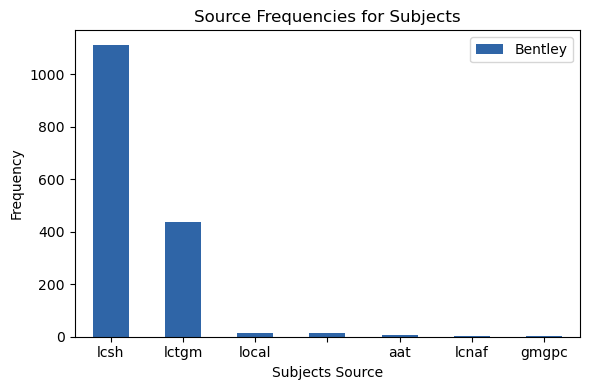

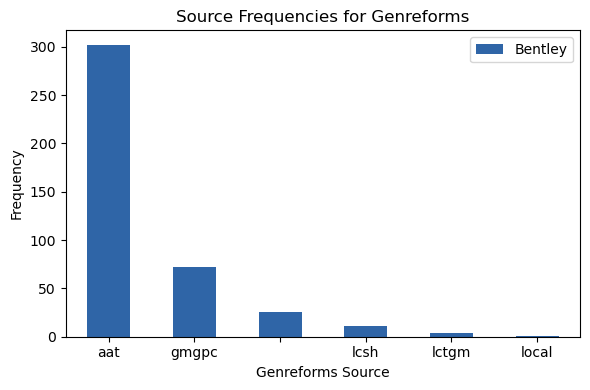

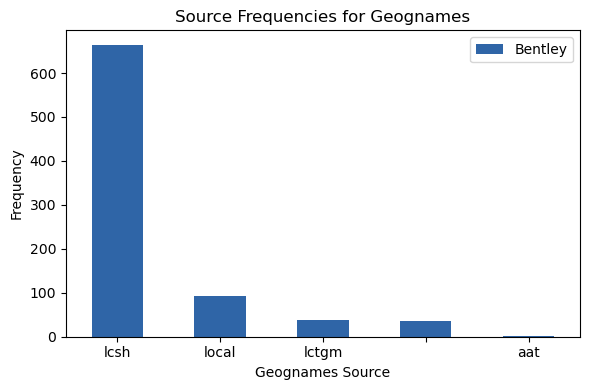

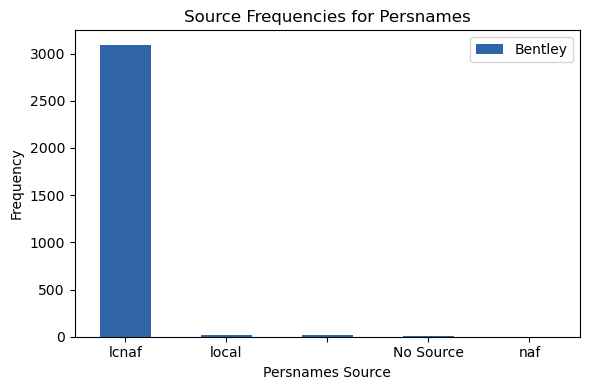

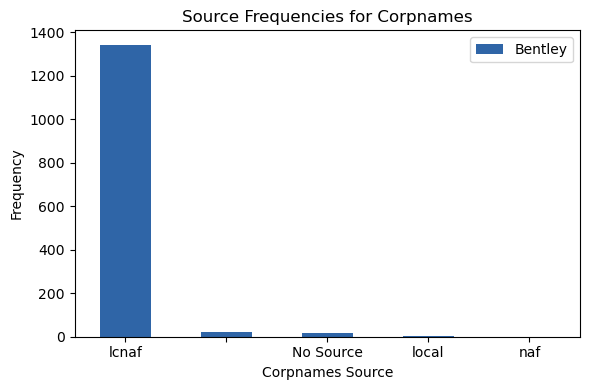

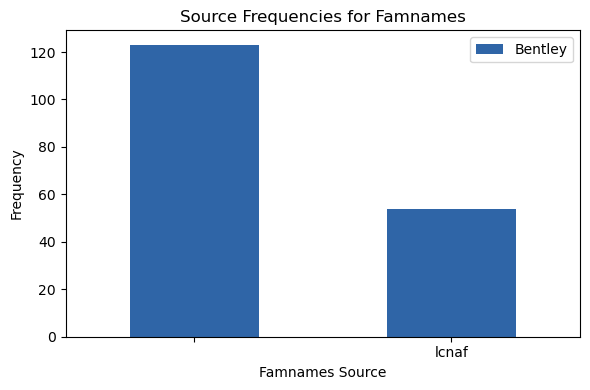

In [16]:
# Call the function for each source column
for column in source_columns:
#    plot_source_frequencies(df1_Bentley, df2_Clements, df3_SCRC, 'df1_Bentley', 'df2_Clements', 'df3_SCRC', column)
    plot_source_frequencies(eads_df, 'df1_Bentley', column)